# Step 1.1: Data Loading & Initial Cleaning

**Objective:** Load the LinkedIn influencers dataset and perform initial cleaning operations.

## Tasks
1. Load data from EDA folder
2. Remove duplicate rows
3. Handle missing critical data (content, reactions, comments)
4. Validate and convert data types
5. Handle content length outliers (remove posts outside 1st-99th percentile)
6. Handle numeric outliers (cap at 99th percentile)
7. Perform data quality checks
8. Save cleaned dataset

**Output:** `../data/cleaned_data.csv`

---
## Setup and Configuration

In [17]:
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path

# Configuration
INPUT_FILE = '../data/linkedin_posts_new.csv'
OUTPUT_DIR = '../data'
OUTPUT_FILE = 'cleaned_data.csv'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✓ Libraries loaded and directories created")

✓ Libraries loaded and directories created


---
## 1. Load Data

In [18]:
print("="*80)
print("LOADING DATA")
print("="*80)

df = pd.read_csv(INPUT_FILE)
initial_rows = len(df)
initial_cols = len(df.columns)

print(f"✓ Loaded: {initial_rows:,} rows × {initial_cols} columns")
print(f"  - Unique influencers: {df['name'].nunique()}")
print(f"  - Columns: {list(df.columns)}")

LOADING DATA
✓ Loaded: 786 rows × 18 columns
  - Unique influencers: 499
  - Columns: ['name', 'headline', 'location', 'followers', 'connections', 'about', 'time_spent', 'content', 'content_links', 'media_type', 'media_url', 'num_hashtags', 'hashtag_followers', 'hashtags', 'reactions', 'comments', 'views', 'votes']


In [19]:
# Display first few rows
df.head(3)

,name,headline,location,followers,connections,about,time_spent,content,content_links,media_type,media_url,num_hashtags,hashtag_followers,hashtags,reactions,comments,views,votes
0,kevinswiber,I’m not famous.,NaN,3690,500,NaN,5,I’m not famous. I’m not even popular. But I ha...,NaN,post,NaN,0,NaN,NaN,65,8,NaN,NaN
1,puneet-bhardwaj-849aa01,AI at the speed of light!,NaN,2546,500,NaN,3,AI at the speed of light! While researching th...,https://lnkd.in/g8eTMBQu; https://www.linkedin...,post,NaN,4,NaN,#EdgeComputing; #MIT; #Innovation; #FutureOfTech,34,2,NaN,NaN
2,jainnitin1983,I wanted to share that I’ve decided to move on...,NaN,3888,500,NaN,1,I wanted to share that I’ve decided to move on...,https://www.linkedin.com/company/kinetix-tradi...,post,NaN,0,NaN,NaN,34,5,NaN,NaN


In [20]:
# Check initial data types
print("\nData Types:")
print(df.dtypes)


Data Types:
name                     str
headline                 str
location             float64
followers              int64
connections            int64
about                float64
time_spent             int64
content                  str
content_links            str
media_type               str
media_url            float64
num_hashtags           int64
hashtag_followers    float64
hashtags                 str
reactions              int64
comments               int64
views                float64
votes                float64
dtype: object


---
## 2. Remove Duplicate Rows

In [21]:
print("="*80)
print("REMOVING DUPLICATES")
print("="*80)

# Check for exact duplicates
duplicates_total = df.duplicated().sum()
print(f"Found {duplicates_total} exact duplicate rows")

if duplicates_total > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates_total} duplicates")
else:
    print("✓ No duplicates found")

# Check for duplicate content
if 'content' in df.columns:
    content_duplicates = df['content'].dropna().duplicated().sum()
    print(f"\nFound {content_duplicates} posts with duplicate content")
    print("ℹ Keeping duplicate content (may be reposts by different influencers)")

print(f"\nRows after duplicate removal: {len(df):,}")

REMOVING DUPLICATES
Found 0 exact duplicate rows
✓ No duplicates found

Found 1 posts with duplicate content
ℹ Keeping duplicate content (may be reposts by different influencers)

Rows after duplicate removal: 786


---
## 3. Handle Missing Critical Data

In [22]:
print("="*80)
print("HANDLING MISSING DATA")
print("="*80)

# Check missing values in critical columns
critical_columns = ['content', 'reactions', 'comments']
missing_summary = {}

print("\nMissing values in critical columns:")
for col in critical_columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        missing_summary[col] = {'count': missing_count, 'pct': missing_pct}
        print(f"  {col}: {missing_count:,} ({missing_pct:.2f}%)")

HANDLING MISSING DATA

Missing values in critical columns:
  content: 0 (0.00%)
  reactions: 0 (0.00%)
  comments: 0 (0.00%)


In [23]:
# Drop rows with missing content
before_drop = len(df)

if 'content' in df.columns:
    df = df[df['content'].notna()].copy()
    removed = before_drop - len(df)
    print(f"\n✓ Removed {removed:,} rows with missing content")

# Drop rows with missing target variables
before_targets = len(df)
if 'reactions' in df.columns and 'comments' in df.columns:
    df = df[(df['reactions'].notna()) & (df['comments'].notna())].copy()
    removed = before_targets - len(df)
    if removed > 0:
        print(f"✓ Removed {removed:,} rows with missing reactions/comments")
    else:
        print(f"✓ All rows have reactions and comments data")

print(f"\nRows after handling missing data: {len(df):,}")


✓ Removed 0 rows with missing content
✓ All rows have reactions and comments data

Rows after handling missing data: 786


---
## 4. Validate and Convert Data Types

In [24]:
print("="*80)
print("VALIDATING DATA TYPES")
print("="*80)

# Convert numeric columns
numeric_cols = ['reactions', 'comments', 'num_hashtags', 'followers', 'hashtag_followers']

for col in numeric_cols:
    if col in df.columns:
        original_type = df[col].dtype
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        nulls_after = df[col].isnull().sum()
        if nulls_after > 0:
            print(f"⚠ {col}: {nulls_after} values couldn't be converted to numeric")
        else:
            print(f"✓ {col}: {original_type} → {df[col].dtype}")

# Ensure reactions and comments are integers and non-negative
if 'reactions' in df.columns:
    df['reactions'] = df['reactions'].fillna(0).astype(int)
    df.loc[df['reactions'] < 0, 'reactions'] = 0
    
if 'comments' in df.columns:
    df['comments'] = df['comments'].fillna(0).astype(int)
    df.loc[df['comments'] < 0, 'comments'] = 0

print("\n✓ Data type conversion complete")

VALIDATING DATA TYPES
✓ reactions: int64 → int64
✓ comments: int64 → int64
✓ num_hashtags: int64 → int64
✓ followers: int64 → int64
⚠ hashtag_followers: 786 values couldn't be converted to numeric

✓ Data type conversion complete


---
## 5. Handle Content Length Outliers

In [25]:
print("="*80)
print("HANDLING CONTENT LENGTH OUTLIERS")
print("="*80)

# Calculate content length
if 'content' in df.columns:
    df['content_length'] = df['content'].str.len()
    
    # Get statistics
    content_lengths = df['content_length'].dropna()
    
    print(f"\nContent Length Statistics:")
    print(f"  Min:        {content_lengths.min():,} characters")
    print(f"  Max:        {content_lengths.max():,} characters")
    print(f"  Mean:       {content_lengths.mean():.0f} characters")
    print(f"  Median:     {content_lengths.median():.0f} characters")
    print(f"  Std Dev:    {content_lengths.std():.0f} characters")
    
    # Calculate percentiles
    p1 = np.percentile(content_lengths, 1)
    p99 = np.percentile(content_lengths, 99)
    
    print(f"\n  1st percentile:   {p1:.0f} characters")
    print(f"  99th percentile:  {p99:.0f} characters")
    
    # Identify outliers
    too_short = (df['content_length'] < p1).sum()
    too_long = (df['content_length'] > p99).sum()
    total_outliers = too_short + too_long
    
    print(f"\nContent Length Outliers:")
    print(f"  Too short (< {p1:.0f}): {too_short:,} rows ({(too_short/len(df))*100:.1f}%)")
    print(f"  Too long (> {p99:.0f}):  {too_long:,} rows ({(too_long/len(df))*100:.1f}%)")
    print(f"  Total outliers:          {total_outliers:,} rows ({(total_outliers/len(df))*100:.1f}%)")
    
    # Remove outliers
    before_removal = len(df)
    df = df[(df['content_length'] >= p1) & (df['content_length'] <= p99)].copy()
    removed = before_removal - len(df)
    
    print(f"\n✓ Removed {removed:,} rows with content length outliers")
    print(f"  Final row count: {len(df):,}")
    
    # Store stats for later
    content_length_stats = {
        'min': float(content_lengths.min()),
        'max': float(content_lengths.max()),
        'mean': float(content_lengths.mean()),
        'median': float(content_lengths.median()),
        'std': float(content_lengths.std()),
        '1st_percentile': float(p1),
        '99th_percentile': float(p99),
        'too_short_removed': int(too_short),
        'too_long_removed': int(too_long),
        'total_removed': int(removed)
    }
else:
    print("⚠ Content column not found")
    content_length_stats = {}

print("\n✓ Content length outlier handling complete")

HANDLING CONTENT LENGTH OUTLIERS

Content Length Statistics:
  Min:        12 characters
  Max:        27,299 characters
  Mean:       2108 characters
  Median:     1136 characters
  Std Dev:    2776 characters

  1st percentile:   26 characters
  99th percentile:  13185 characters

Content Length Outliers:
  Too short (< 26): 6 rows (0.8%)
  Too long (> 13185):  8 rows (1.0%)
  Total outliers:          14 rows (1.8%)

✓ Removed 14 rows with content length outliers
  Final row count: 772

✓ Content length outlier handling complete


---
## 6. Handle Numeric Outliers

In [26]:
print("="*80)
print("HANDLING NUMERIC OUTLIERS")
print("="*80)

def detect_and_handle_outliers(df, column, method='cap', percentile=99):
    """
    Detect and handle outliers in a numeric column.
    """
    if column not in df.columns or df[column].isnull().all():
        return df, {}
    
    values = df[column].dropna()
    threshold = np.percentile(values, percentile)
    outliers = (values > threshold).sum()
    
    stats = {
        'min': values.min(),
        'max': values.max(),
        'mean': values.mean(),
        'median': values.median(),
        f'{percentile}th_percentile': threshold,
        'outliers_count': outliers,
        'outliers_pct': (outliers / len(values)) * 100
    }
    
    if method == 'cap' and outliers > 0:
        df[column] = df[column].clip(upper=threshold)
        print(f"  {column}:")
        print(f"    - Outliers: {outliers:,} ({stats['outliers_pct']:.1f}%)")
        print(f"    - Capped at: {threshold:.0f}")
        print(f"    - Range: {stats['min']:.0f} to {threshold:.0f}")
    
    return df, stats

# Handle outliers
outlier_stats = {}

print("\nCapping outliers at 99th percentile:\n")
for col in ['reactions', 'comments', 'followers']:
    if col in df.columns:
        df, stats = detect_and_handle_outliers(df, col, method='cap', percentile=95)
        outlier_stats[col] = stats

print("\n✓ Outlier handling complete")

HANDLING NUMERIC OUTLIERS

Capping outliers at 99th percentile:

  reactions:
    - Outliers: 39 (5.1%)
    - Capped at: 1670
    - Range: 1 to 1670
  comments:
    - Outliers: 39 (5.1%)
    - Capped at: 154
    - Range: 0 to 154
  followers:
    - Outliers: 30 (3.9%)
    - Capped at: 1174428
    - Range: 80 to 1174428

✓ Outlier handling complete


---
## 7. Data Quality Checks

In [27]:
print("="*80)
print("DATA QUALITY CHECKS")
print("="*80)

quality_issues = []

# Check for negative values
for col in ['reactions', 'comments', 'followers', 'num_hashtags']:
    if col in df.columns:
        negatives = (df[col] < 0).sum()
        if negatives > 0:
            quality_issues.append(f"{col} has {negatives} negative values")
            df[col] = df[col].clip(lower=0)

# Check for empty content
if 'content' in df.columns:
    empty_content = (df['content'].str.strip() == '').sum()
    if empty_content > 0:
        quality_issues.append(f"{empty_content} posts have empty content")
        df = df[df['content'].str.strip() != '']

# Check for unrealistic values
if 'reactions' in df.columns and 'followers' in df.columns:
    unrealistic = (df['reactions'] > df['followers'] * 10).sum()
    if unrealistic > 0:
        quality_issues.append(f"{unrealistic} posts have reactions > 10x followers")

if quality_issues:
    print("⚠ Quality issues found and fixed:")
    for issue in quality_issues:
        print(f"  - {issue}")
else:
    print("✓ No critical quality issues found")

print(f"\nFinal row count: {len(df):,}")

DATA QUALITY CHECKS
✓ No critical quality issues found

Final row count: 772


---
## 8. Summary Statistics

In [28]:
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

final_rows = len(df)
rows_removed = initial_rows - final_rows
removal_pct = (rows_removed / initial_rows) * 100

print(f"\nData Transformation:")
print(f"  Initial rows:     {initial_rows:,}")
print(f"  Rows removed:     {rows_removed:,} ({removal_pct:.1f}%)")
print(f"  Final rows:       {final_rows:,}")
print(f"  Retention rate:   {(final_rows/initial_rows)*100:.1f}%")

SUMMARY STATISTICS

Data Transformation:
  Initial rows:     786
  Rows removed:     14 (1.8%)
  Final rows:       772
  Retention rate:   98.2%


In [29]:
# Target variable statistics
print("\n" + "="*80)
print("TARGET VARIABLE STATISTICS")
print("="*80)

if 'reactions' in df.columns:
    print(f"\nReactions:")
    print(f"  Min:      {df['reactions'].min():,}")
    print(f"  Max:      {df['reactions'].max():,}")
    print(f"  Mean:     {df['reactions'].mean():.0f}")
    print(f"  Median:   {df['reactions'].median():.0f}")
    print(f"  Std Dev:  {df['reactions'].std():.0f}")

if 'comments' in df.columns:
    print(f"\nComments:")
    print(f"  Min:      {df['comments'].min():,}")
    print(f"  Max:      {df['comments'].max():,}")
    print(f"  Mean:     {df['comments'].mean():.0f}")
    print(f"  Median:   {df['comments'].median():.0f}")
    print(f"  Std Dev:  {df['comments'].std():.0f}")


TARGET VARIABLE STATISTICS

Reactions:
  Min:      1.0
  Max:      1,669.8999999999999
  Mean:     251
  Median:   64
  Std Dev:  427

Comments:
  Min:      0.0
  Max:      153.89999999999986
  Mean:     24
  Median:   4
  Std Dev:  40


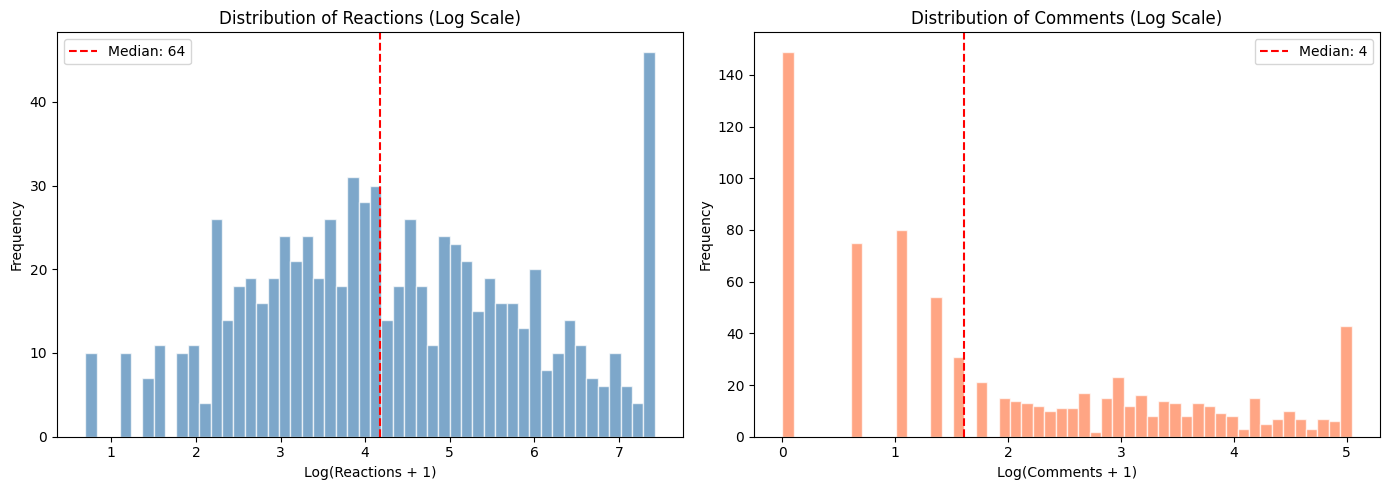

In [30]:
# Visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reactions distribution
if 'reactions' in df.columns:
    axes[0].hist(np.log1p(df['reactions']), bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    axes[0].set_xlabel('Log(Reactions + 1)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Reactions (Log Scale)')
    axes[0].axvline(np.log1p(df['reactions'].median()), color='red', linestyle='--', 
                    label=f'Median: {df["reactions"].median():.0f}')
    axes[0].legend()

# Comments distribution
if 'comments' in df.columns:
    axes[1].hist(np.log1p(df['comments']), bins=50, color='coral', edgecolor='white', alpha=0.7)
    axes[1].set_xlabel('Log(Comments + 1)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Comments (Log Scale)')
    axes[1].axvline(np.log1p(df['comments'].median()), color='red', linestyle='--', 
                    label=f'Median: {df["comments"].median():.0f}')
    axes[1].legend()

plt.tight_layout()
plt.show()

---
## 9. Save Cleaned Data

In [31]:
print("="*80)
print("SAVING CLEANED DATA")
print("="*80)

# Save cleaned dataframe
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)
df.to_csv(output_path, index=False)
print(f"✓ Saved cleaned data to: {output_path}")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Save statistics
stats_summary = {
    'initial_rows': int(initial_rows),
    'final_rows': int(final_rows),
    'rows_removed': int(rows_removed),
    'removal_percentage': float(removal_pct),
    'duplicates_removed': int(duplicates_total),
    'missing_content': int(missing_summary.get('content', {}).get('count', 0)),
    'content_length_outliers_removed': content_length_stats.get('total_removed', 0),
    'quality_issues_fixed': len(quality_issues),
    'content_length_stats': content_length_stats,
    'outlier_stats': {k: {ik: float(iv) if isinstance(iv, (int, float, np.number)) else iv 
                          for ik, iv in v.items()} 
                     for k, v in outlier_stats.items()}
}

stats_path = os.path.join(OUTPUT_DIR, 'cleaning_stats.json')
with open(stats_path, 'w') as f:
    json.dump(stats_summary, f, indent=2)

print(f"✓ Saved statistics to: {stats_path}")

SAVING CLEANED DATA
✓ Saved cleaned data to: ../data\cleaned_data.csv
  Shape: 772 rows × 19 columns
✓ Saved statistics to: ../data\cleaning_stats.json


---
## ✅ Step 1.1 Complete

**Summary:**
- ✓ Data loaded successfully
- ✓ Duplicates removed
- ✓ Missing values handled
- ✓ Data types validated
- ✓ Content length outliers removed (1st-99th percentile)
- ✓ Numeric outliers capped (reactions, comments, followers)
- ✓ Quality checks passed
- ✓ Clean data saved

**Output Files:**
- `../data/cleaned_data.csv` - Clean dataset ready for preprocessing
- `../data/cleaning_stats.json` - Detailed statistics

**Next Step:** Step 1.2 - Text Preprocessing